# Finding the Hollywood Formula: IMDB Movie Dataset Analysis

<img src="dataset-cover.png"/>

### Motivation
As a group, we are huge movie fanatics and enjoy great films such as the Godfather, Casablanca, and any Tarantino flick. As data scientists we wanted to dig deeper into the business side of movies and explore the economics behind what makes a successful movie. Basically we wanted to to examine whether there are any trends among films that lead them to become successful at the box office, and whether a film's box office success correlates with its ratings. A useful analysis would help us predict how well a film does at the box office before it screens, without having to rely on critics or our own instinct. Essentially we want to determine if there is a "Hollywood formula" to making a successful movie. 

### Background
We found an interesting dataset of more than 5000 data points consisting of 28 attributes describing IMDB movies here: https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset.

You can read more about the data set here: https://blog.nycdatascience.com/student-works/machine-learning/movie-rating-prediction/. 

### Original Problem
Kaggle user **chuansun76** was trying to solve the following problem:
1. Given that thousands of movies were produced each year, is there a better way for us to tell the greatness of movie without relying on critics or our own instincts?
2. Will the number of human faces in movie poster correlate with the movie rating?

### Our Problem
We decided to tackle the problem by trying to answer the following questions: 
1. Does the genre, imdb score, and popularity of the cast impact a film's success at the box office?
2. Are there any movies with a high gross-to-budget ratio (ROI), and why? 


First, let's install any packages and libraries we might need.

In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *
import seaborn as sns
%matplotlib inline

# for machine learning
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import r2_score

C:\Users\mphil\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## I. Data Collection
We provided two ways to obtain the data scraped by chuansun76, either downloading the data directly online or simply reading in the downloaded file from our inputs folder.

In [6]:
DATA_URL = "https://raw.githubusercontent.com/sundeepblue/movie_rating_prediction/master/movie_metadata.csv"
FILE_PATH = "input/movie_metadata.csv"

def load_data_online(data_url):
    data = None
    SUCCESS = 200
    
    r = requests.get(data_url)
    if r.status_code == SUCCESS:
        # Decode data and read it into a DataFrame
        content = r.content.decode('utf-8')
        cr = csv.reader(content.splitlines(), delimiter=',')
        my_list = list(cr)
        data = pd.DataFrame(my_list[1:], columns=my_list[0])
        return data
    
# movies_table = load_data_online(DATA_URL)
movies_table = pd.read_csv(FILE_PATH)
movies_table.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## II. Data Processing
For our analysis we will be dropping any rows with nil values for gross, budget, title_year, and country, as those data points won't contribute to our analysis. We will also be focusing on movies produced domestically, so we will drop all rows pertaining to movies produced in foreign countries.

In [8]:
movies_table = pd.read_csv("input/movie_metadata.csv")

# replace na values with 0
movies_table["gross"].fillna(0, inplace=True)
movies_table["budget"].fillna(0, inplace=True)
movies_table["title_year"].fillna(0, inplace=True)
movies_table["country"].fillna("NaN", inplace=True)

# only consider movies made in the USA. Drop all other rows
movies_table.drop(movies_table[-(movies_table["country"].str.contains("USA"))].index, inplace=True)

movies_table.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0


To be able to compare movies across different years, we will need to convert gross and budget values into real dollar amounts, in terms of 2016 purchasing power. To accomplish this we will use the Consumer Price Index (CPI) to adjust for inflation. But first, let's scrape CPI values for every year from 1912-2016 exclusively. 

In [9]:
url = "http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/"

r = requests.get(url)
data = r.text
soup = BeautifulSoup(data, 'html.parser')

table = soup.find('table')
rows = table.tbody.findAll('tr');

years = []
cpis = []

for row in rows:
    year = row.findAll('td')[0].get_text()
    if year.isdigit() and int(year) < 2017:
        years.append(int(year))
        cpis.append(float(row.findAll('td')[13].get_text()))

cpi_table = pd.DataFrame({
    "year": years,
    "avg_annual_cpi": cpis
})

cpi_table.head()

,avg_annual_cpi,year
0,9.9,1913
1,10.0,1914
2,10.1,1915
3,10.9,1916
4,12.8,1917


Transform the budget and gross for each movie into real 2016 dollar terms. Drop the nominal value columns, as those won't contribute to our analysis.

In [10]:
real_domestic_gross = []
real_budget_values = []
cpi_2016 = float(cpi_table[cpi_table['year'] == 2016]['avg_annual_cpi'])

# function that translates nominal dollars into real dollars in 2016 using CPI 
def get_real_value(nominal_amt, old_cpi, cpi_2016):
    real_value = (nominal_amt * cpi_2016) / old_cpi
    return real_value

# drop all rows in movies_table with a budget, gross, or year of 0, as those rows won't contribute to our analysis
movies_table.drop(movies_table[(movies_table["budget"] == 0) | (movies_table["gross"] == 0) | 
                                (movies_table["title_year"] == 0)].index, inplace=True)


# must transform gross and budget values into real 2016 dollar terms
for index, row in movies_table.iterrows():
    gross = row['gross']
    budget = row['budget']
    year = row['title_year']
    cpi = float(cpi_table[cpi_table['year'] == int(year)]['avg_annual_cpi'])
    
    real_gross = get_real_value(gross, cpi, cpi_2016)
    real_budget = get_real_value(budget, cpi, cpi_2016)
    real_domestic_gross.append(real_gross)
    real_budget_values.append(real_budget)

movies_table["real_domestic_gross"] = real_domestic_gross
movies_table["real_budget"] = real_budget_values

# drop the gross and budget cols because we don't care about nominal values
movies_table.drop(labels='gross', axis=1, inplace=True)
movies_table.drop(labels='budget', axis=1, inplace=True)

movies_table.head()   

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,...,language,country,content_rating,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_domestic_gross,real_budget
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,English,USA,PG-13,2009.0,936.0,7.9,1.78,33000,8.507937e+08,2.651368e+08
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,Action|Adventure|Fantasy,Johnny Depp,...,English,USA,PG-13,2007.0,5000.0,7.1,2.35,0,3.582208e+08,3.473329e+08
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,Action|Thriller,Tom Hardy,...,English,USA,PG-13,2012.0,23000.0,8.5,2.35,164000,4.684551e+08,2.613385e+08
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,English,USA,PG-13,2012.0,632.0,6.6,2.35,24000,7.637218e+07,2.756598e+08
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,Action|Adventure|Romance,J.K. Simmons,...,English,USA,PG-13,2007.0,11000.0,6.2,2.35,0,3.896268e+08,2.987063e+08


Let's also calculate the return on investment (ROI) and absolute profit for each movie. The ROI will show which movie studio earned the greatest profit based on their initial budget for the movie, and will be useful in evaluating the sucess of a film in an economic sense. **We will be storing the ROI values as percentages.**

In [11]:
profits = []
roi_vals = []

for index, row in movies_table.iterrows():
    profit = row['real_domestic_gross'] - row['real_budget']
    budget = row['real_budget']
    num = profit - budget
    den = budget
    # convert roi to percentage
    roi = (num / den) * 100
    
    profits.append(profit)
    roi_vals.append(roi)
    
movies_table['profit'] = profits
movies_table['roi'] = roi_vals

movies_table.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,...,content_rating,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,real_domestic_gross,real_budget,profit,roi
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,PG-13,2009.0,936.0,7.9,1.78,33000,8.507937e+08,2.651368e+08,5.856569e+08,120.888543
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,Action|Adventure|Fantasy,Johnny Depp,...,PG-13,2007.0,5000.0,7.1,2.35,0,3.582208e+08,3.473329e+08,1.088790e+07,-96.865283
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,Action|Thriller,Tom Hardy,...,PG-13,2012.0,23000.0,8.5,2.35,164000,4.684551e+08,2.613385e+08,2.071167e+08,-20.747743
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,PG-13,2012.0,632.0,6.6,2.35,24000,7.637218e+07,2.756598e+08,-1.992877e+08,-172.294775
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,Action|Adventure|Romance,J.K. Simmons,...,PG-13,2007.0,11000.0,6.2,2.35,0,3.896268e+08,2.987063e+08,9.092051e+07,-69.561898


Now that we have tidied and processed the data, adding new data that will aid our analysis, we can proceed to the next step of the data science pipeline. 

## III. Exploratory Analysis and Data Visualization

### Analyzing imdb score vs. gross
let's see if these is a relationship between a film's imdb score and its box office gross

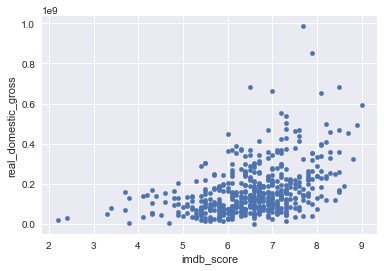

In [12]:
x = 'imdb_score'
y = 'real_domestic_gross'

# choose a subset to represent the dataset
subset_data = movies_table.head(500)[[x, y]]
subset_data.sort_values(['imdb_score'], ascending=True, inplace=True)
subset_data.dropna(inplace=True)

subset_data.plot(x=x, y=y, kind='scatter')

It is interesting to see how there is almost an exponential relationship between a film's imdb score and its box office gross. Let's also create violin plots based on this relationship to better visualize the spread and density of the data distribution.

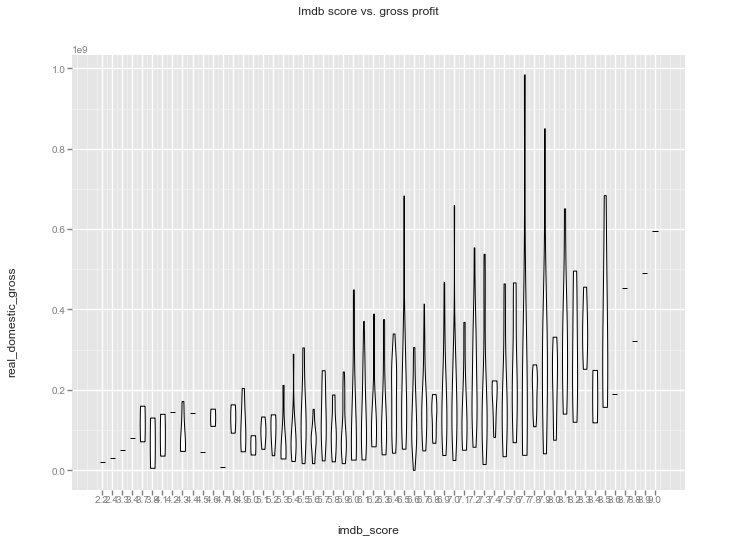

<ggplot: (128041984509)>

In [13]:
ggplot(aes(x=x, y=y), data=subset_data) +\
    geom_violin() +\
    labs(title="Imdb score vs. gross profit",
         x = x,
         y = y)

Mention analysis of violin plots

### Analyzing imdb score vs. gross by genre

Next, we wanted to analyze if genre played a role in the correlation betwen imdb score and gross. In our original data set, each movie could have multiple genres and so we split each row into multiple based on how many genres the movies were classified as part of. 

In [14]:
# Subset data #2
subset_data2 = pd.DataFrame(columns=[x, y, 'genre'])

i = 0
values = []
for idx, row in movies_table.iterrows():
    genres_val = row['genres']
    
    if not pd.isnull(genres_val) and not pd.isnull(row['real_domestic_gross']):
        for genre in genres_val.split('|'):
            values.append([row[x], row[y], genre])    
        
subset_data2 = pd.DataFrame(values, columns=[x, y, 'genre'])
subset_data2 = subset_data2.groupby(['imdb_score', 'genre'], as_index=False).mean()

Now let's graph the imdb score vs. gross relationship for each genre in our dataset. 

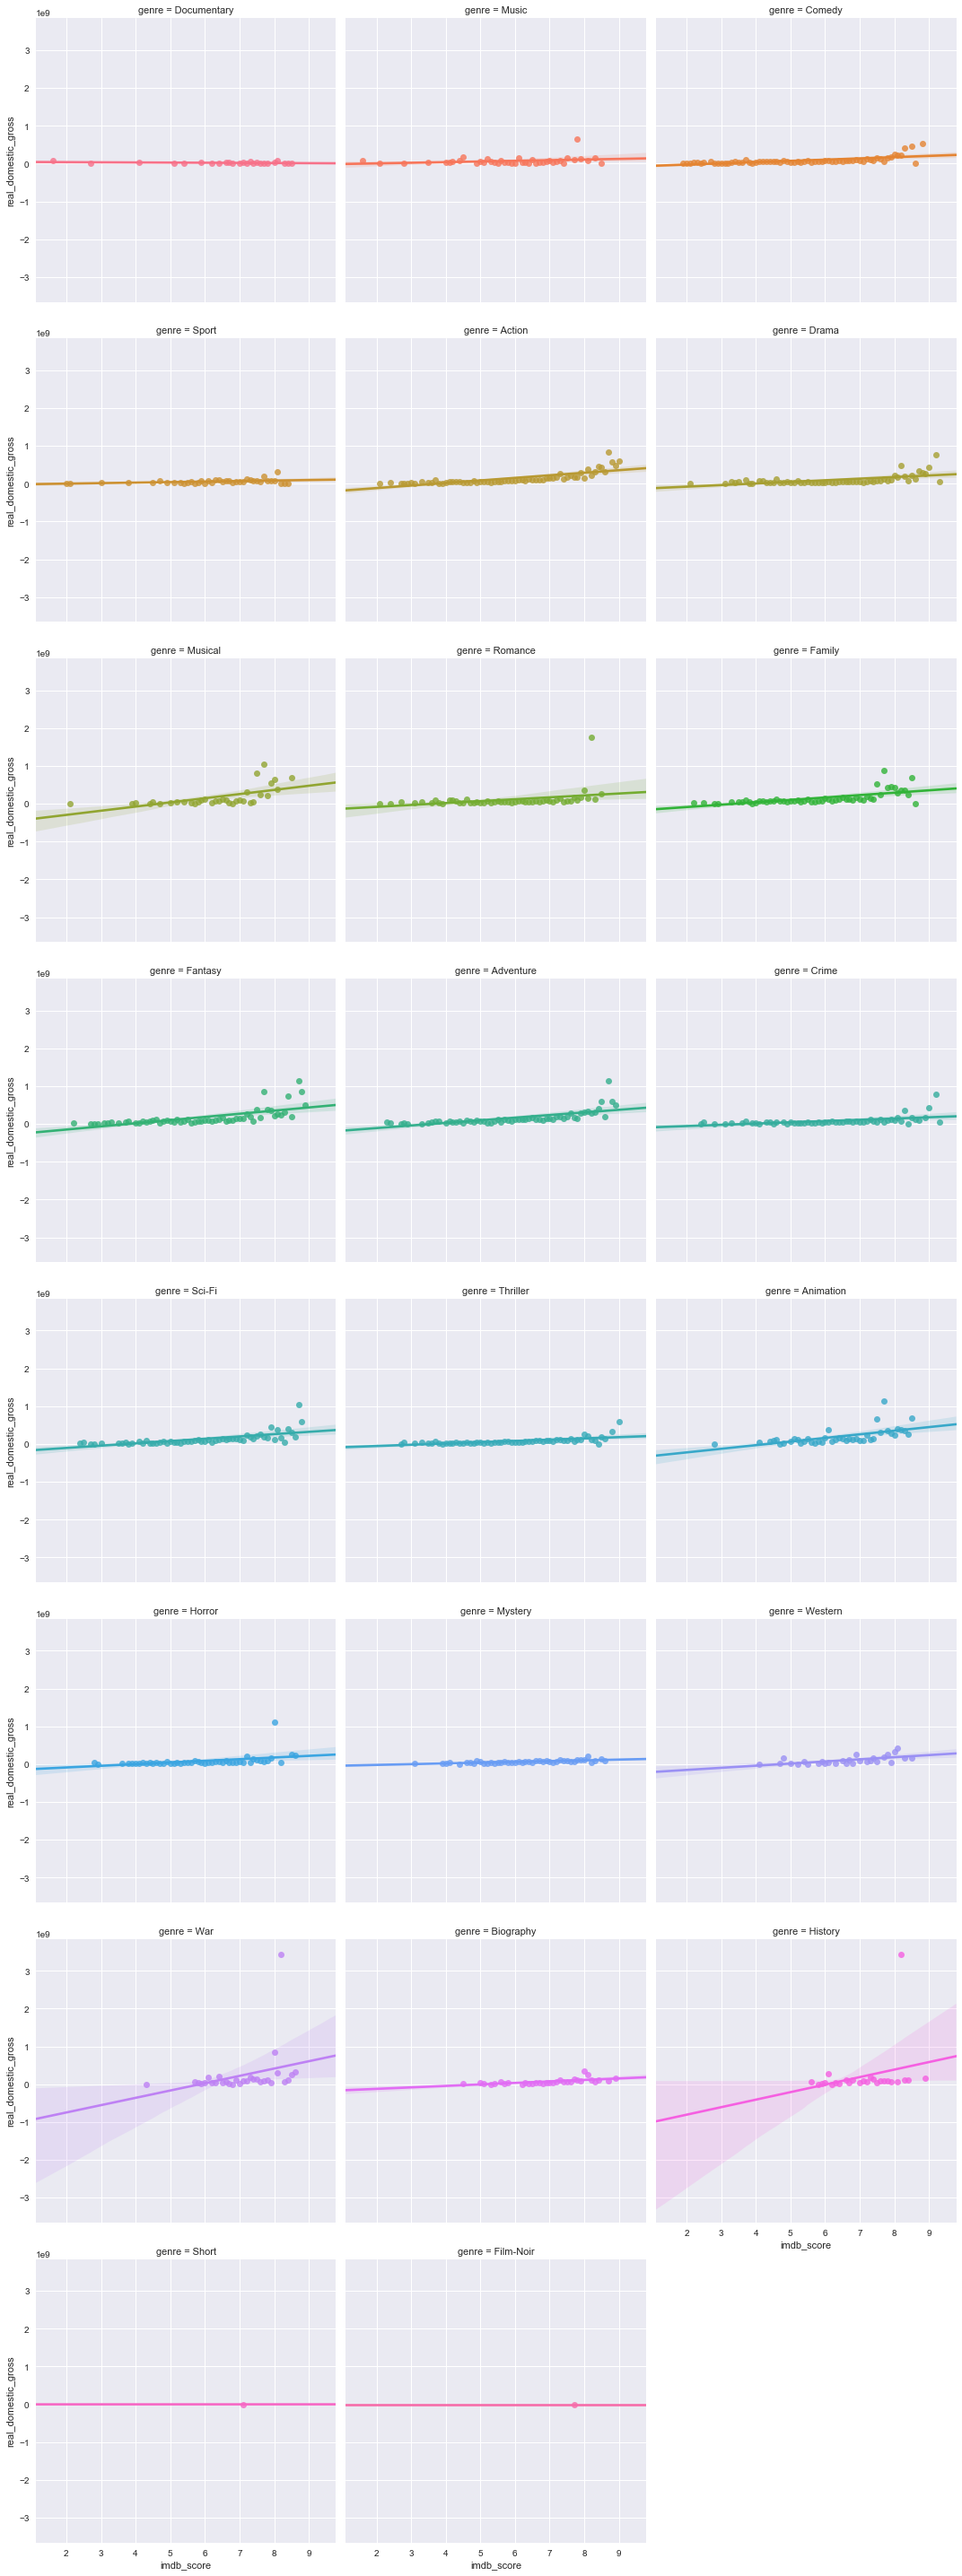

In [15]:
# Plot the data
g = sns.lmplot(x=x, y=y, data=subset_data2, col="genre", hue="genre", scatter=True, fit_reg=True, col_wrap=3)
sns.plt.show()

Mention analysis of above graphs in at least a paragraph.

### Analyzing film earnings
Next, let's turn our analysis onto ROI and which films brought studios the most bang for their buck.

In [16]:
movies_by_roi = movies_table.sort_values('roi', ascending=False)

for index, row in movies_by_roi.head().iterrows():
    print(row["movie_title"], row["roi"])

Paranormal Activity  719248.5533333333
Tarnation  271366.05504587153
The Blair Witch Project  234016.85666666666
The Brothers McMullen  40786.40000000001
The Texas Chain Saw Massacre  36742.72853517215


Out of all the movies produced by Hollywood, Paranormal Activity, the 2009 indie horror film, yielded the greatest ROI. With a budget of around \$15,000, it grossed \$107,917,283 at the box office during its run in 2010. We found this statistic to be quite amazing. It is also interesting to see how out of the top 5 movies with greatest ROI in our dataset, 3/5 films are horror. 

Let's group the movies by greatest absolute profit.

In [17]:
movies_by_profit = movies_table.sort_values('profit', ascending=False)

for index, row in movies_by_profit.head().iterrows():
    print(row["movie_title"], row["profit"])

Gone with the Wind  3361449602.0105033
Snow White and the Seven Dwarfs  3048847005.4440975
Star Wars: Episode IV - A New Hope  1781975398.5091584
Pinocchio  1400612278.5714285
Fantasia  1270665631.4285712


Let's group the movies by greatest real domestic gross at the box office.

In [18]:
movies_by_gross = movies_table.sort_values('real_domestic_gross', ascending=False)

for index, row in movies_by_gross.head().iterrows():
    print(row["movie_title"], row["real_domestic_gross"])

Gone with the Wind  3430119230.7155395
Snow White and the Seven Dwarfs  3082181310.999653
Star Wars: Episode IV - A New Hope  1825541025.5718646
Pinocchio  1445185007.142857
Fantasia  1309752485.7142856


Let's group the movies by greatest imdb scores.

In [19]:
movies_by_score = movies_table.sort_values('imdb_score', ascending=False)

for index, row in movies_by_score.head().iterrows():
    print(row["movie_title"], row["imdb_score"], row["real_domestic_gross"])

The Shawshank Redemption  9.3 45898454.45535088
The Godfather  9.2 774119909.896268
The Dark Knight  9.0 594509077.2187428
The Godfather: Part II  9.0 278953369.168357
Pulp Fiction  8.9 174790523.0094467


Add a summarizing note to this analysis

## IV. Analysis, Hypothesis Testing, and ML

In [20]:
movies_table.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'genres', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'title_year', 'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'real_domestic_gross', 'real_budget', 'profit',
       'roi'],
      dtype='object')

Let's do linear regression in order to get more insight about our data.

Linear regression was oringinally developed in statistics to find the relationship between input and output variables. X variables (predictors) are mapped to y values (response). The linear regression then tries to fit a line that fits the points best as possible. How do we define a line that fits as best as possible? We want to minimize the error (aka loss) between the line and the points found in the data. There are different kinds of loss functions that you could utilize in order to measure the loss. The loss function used for linear regression is **Ordinary Least Squares** 

You can learn more about linear regression and its role in machine learning here: http://machinelearningmastery.com/linear-regression-for-machine-learning/

In [21]:
new_data = movies_table.dropna()

x_columns = ['imdb_score', 'real_budget', 'num_critic_for_reviews', 'director_facebook_likes',
             'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
             'movie_facebook_likes', 'cast_total_facebook_likes']
y_column = 'real_domestic_gross'


X = [list(row.values) for _, row in new_data[x_columns].iterrows()]
X_OLS = sm.add_constant(X)
y = new_data[y_column].values


model = sm.OLS(y, X_OLS)
model.data.xnames = ['const'] + x_columns
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     87.69
Date:                Thu, 18 May 2017   Prob (F-statistic):          4.54e-145
Time:                        16:22:50   Log-Likelihood:                -59975.
No. Observations:                2987   AIC:                         1.200e+05
Df Residuals:                    2977   BIC:                         1.200e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                     -1.803e+08   1.51e+07    -11.901      0.000      -2.1e+08 -1.51e+08
imdb_score                 3.272e+07   2.43e+06     13.492      0.000       2.8e+07  3.75e+07
real_budget                   0.9645      0.051     18.867      0.000         0.864     1.065
num_critic_for_reviews    -1.381e+04   2.89e+04     -0.478      0.633     -7.05e+04  4.28e+04
director_facebook_likes     589.3956    718.648      0.820      0.412      -819.702  1998.494
actor_1_facebook_likes    -9357.4739   2016.709     -4.640      0.000     -1.33e+04 -5403.190
actor_2_facebook_likes    -9581.0271   2131.094     -4.496      0.000     -1.38e+04 -5402.461
actor_3_facebook_likes     -1.01e+04   3312.501     -3.049      0.002     -1.66e+04 -3604.240
movie_facebook_likes        124.1345    154.513      0.803      0.422      -178.829   427.098
cast_total_facebook_likes  9090.3678   2012.483      4.517      0.000      5144.370   1.3e+04
==============================================================================
Omnibus:                     5361.692   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9071676.065
Skew:                          12.645   Prob(JB):                         0.00
Kurtosis:                     271.793   Cond. No.                     4.76e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Which variables are significant? Which aren't**
By looking at the p-values and using a significance level of 5%, we can see that imdb_score, real_budget, actor facebook likes, and cast total face book likes are all significant variables. On the other hand, num_critic_for_reviews, director_facebook_likes, and movie_facebook_likes aren't significant because their p-values are all greater than 0.05.

**Interpretations for significant variables**

An increase of imdb score of 1 *increases* the gross profit on average by 3000000, holding all other predictors constant.

An increase of budget by 1 *increases* the gross profit on average by 0, holding all other predictors constant.

An increase of the actor 1's facebook likes by 1 *decreases* the gross profit by 9357.47, holding all other predictors constant.

An increase of the actor 2's facebook likes by 1 *decreases* the gross profit by 9571.03, holding all other predictors constant.

An increase of the actor 3's facebook likes by 1 *decreases* the gross profit by 10100.00, holding all other predictors constant.

An increase of the cast total facebook likes by 1 *increases* the gross profit by 9090.37, holding all other predictors constant.

Most of the results make sense: A higher score, budget, and cast total facebook likes led to a higher gross profit. What was most surprising about these results was the fact that if the main actors had an increase of fb likes, the gross profit actually went down. This could be due to some correlation to the cast total facebook likes. 

Next we are going to use **decision trees** and **cross validation**.

Decision trees are a type of machine learning classifier that attempts to predict a value based on a set of decision rules. Decision trees learn from data in order to create a set of decision rules (if-then-else statements) that predicts values.  

Cross validation is a way of testing if our classification works well. We are given a set of data in which we choose to split it up into two groups known as training and testing (normally there is a lot more training data than testing so it's usually skewed towards something like 70/30 split). We will use the training data to allow our decision tree to be built. Then we will use the testing data in order to see how well our classifier does. If it doens't do as well as we expected, we may have overfitted our classifier on the training data and so we may need to prune the tree by changing specific parameters. This is the basic rundown for cross validation.

You can learn more about these machine learning concepts from the sklearn documentation found here:

*Decision Trees:* http://scikit-learn.org/stable/modules/tree.html
*Cross Validation:* http://scikit-learn.org/stable/modules/cross_validation.html

In [30]:
from sklearn.metrics import mean_absolute_error

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

classifier = tree.DecisionTreeRegressor()
classifier = classifier.fit(X_train, y_train)
# y_pred = classifier.fit(X_train, y_train).predict(X_val)
# # accuracy_training = accuracy_score(y_val, y_pred)

r2 = r2_score(y_val, y_pred)
r2
# error = mean_absolute_error(y_val, y_pred)
# error

-1.3384141378216827

In [24]:
import pydotplus 
from sklearn import tree
from IPython.display import Image 

dot_data = tree.export_graphviz(classifier, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

InvocationException: GraphViz's executables not found

## V. Insight & Policy Decision